# Preliminary

Preliminary simulation for EuRoC 2024 Concept Report


In [36]:
import datetime
from rocketpy import Environment, SolidMotor, Rocket, Flight

## Setup


### 1 - Environment

Assuming:

- Launch day is 12/10/2024
- Launch elevation is what is listed [here](https://www.google.com/maps/place/39%C2%B023'24.6%22N+8%C2%B017'21.1%22W/@39.390161,-8.2917639,17z/data=!3m1!4b1!4m4!3m3!8m2!3d39.390161!4d-8.289189?entry=ttu&g_ep=EgoyMDI0MTAwNy4xIKXMDSoASAFQAw%3D%3D)



Gravity Details

Acceleration of gravity at surface level:    9.8007 m/s²
Acceleration of gravity at   1.000 km (ASL): 9.7981 m/s²


Launch Site Details

Launch Date: 2024-10-12 15:31:09 UTC
Launch Site Latitude: 39.39016°
Launch Site Longitude: -8.28919°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 44399.05 W    4373440.65 N
Launch Site UTM zone: 30S
Launch Site Surface Elevation: 160.0 m


Atmospheric Model Details

Atmospheric Model Type: custom_atmosphere
custom_atmosphere Maximum Height: 1.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 8.70 m/s
Surface Wind Direction: 313.00°
Surface Wind Heading: 133.00°
Surface Pressure: 994.18 hPa
Surface Temperature: 287.11 K
Surface Air Density: 1.206 kg/m³
Surface Speed of Sound: 339.64 m/s


Earth Model Details

Earth Radius at Launch site: 6369.57 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034



Gravity Model Plots


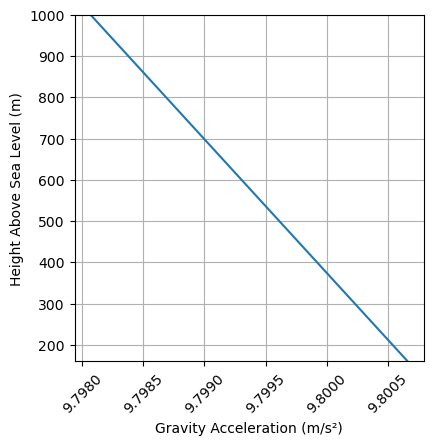



Atmospheric Model Plots


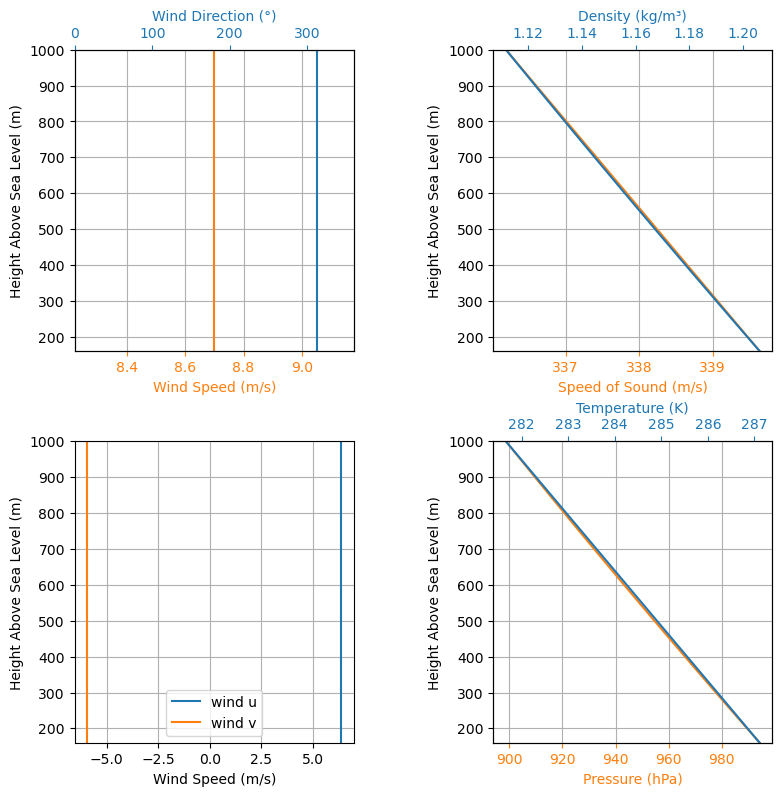

In [37]:
launchpad = Environment(
    latitude=39.390161,
    longitude=-8.289189,
    elevation=160,
    date=(datetime.datetime.now() + datetime.timedelta(days=1)),
)

# launchpad.set_atmospheric_model(
#     type="Forecast",
#     file="GFS",
# )
launchpad.set_atmospheric_model(
    type="custom_atmosphere",
    wind_u = [(0, 6.3627)],
    wind_v = [(0 , -5.933)]
)

#print(launchpad.wind_us)

launchpad.all_info()

### 2 - Motor


Nozzle Details
Nozzle Radius: 0.0375 m
Nozzle Throat Radius: 0.0125 m

Grain Details
Number of Grains: 3
Grain Spacing: 0.005 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.0375 m
Grain Inner Radius: 0.029 m
Grain Height: 0.157 m
Grain Volume: 0.000 m3
Grain Mass: 0.506 kg

Motor Details
Total Burning Time: 5.33 s
Total Propellant Mass: 1.518 kg
Average Propellant Exhaust Velocity: 2261.156 m/s
Average Thrust: 644.008 N
Maximum Thrust: 764.97 N at 2.043 s after ignition.
Total Impulse: 3432.563 Ns



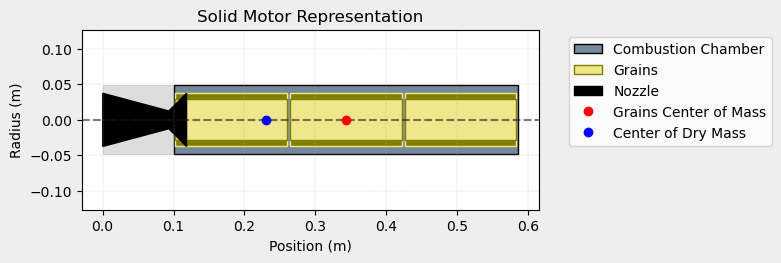

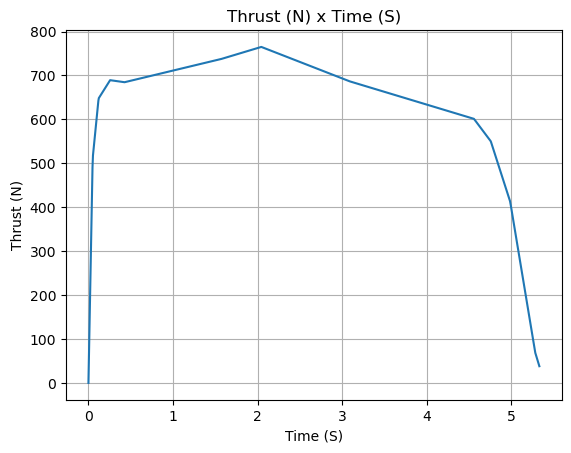

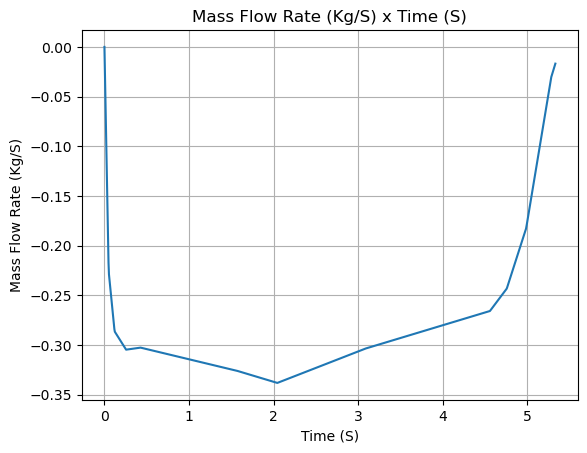

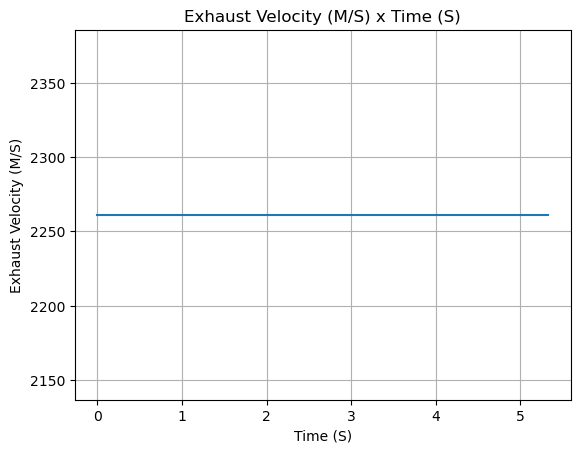

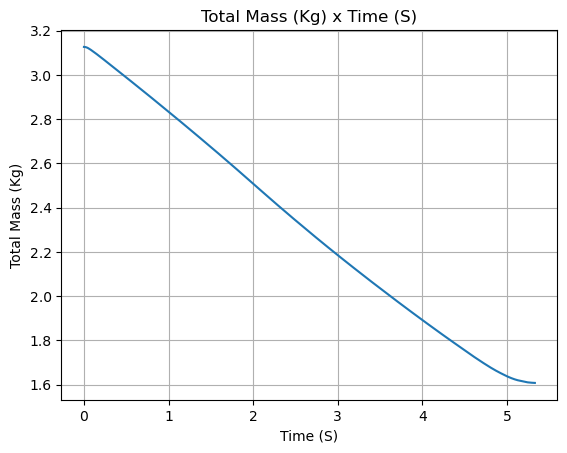

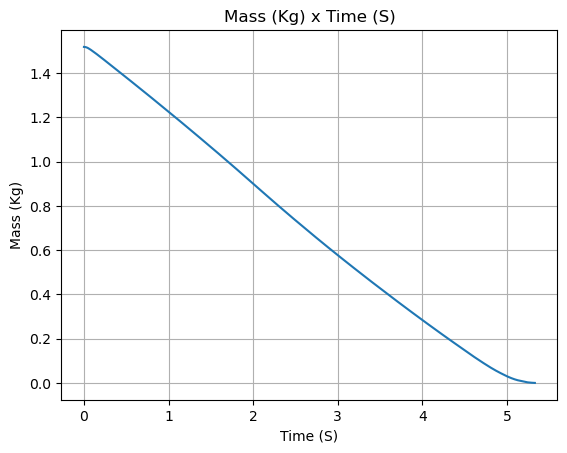

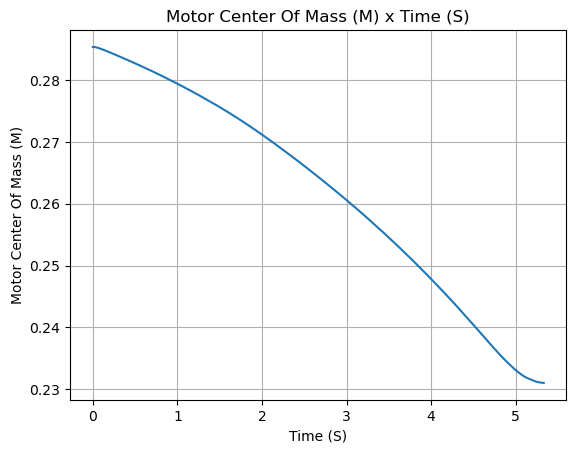

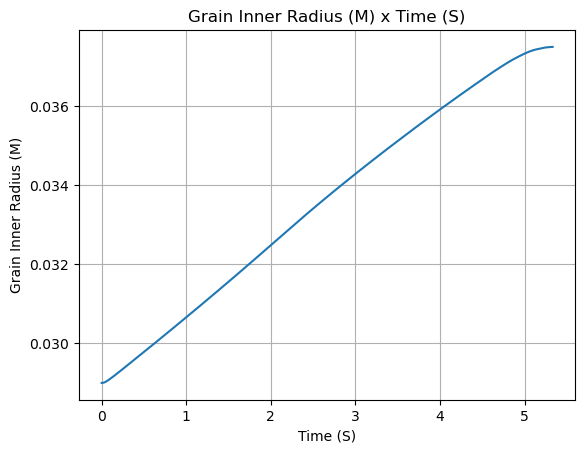

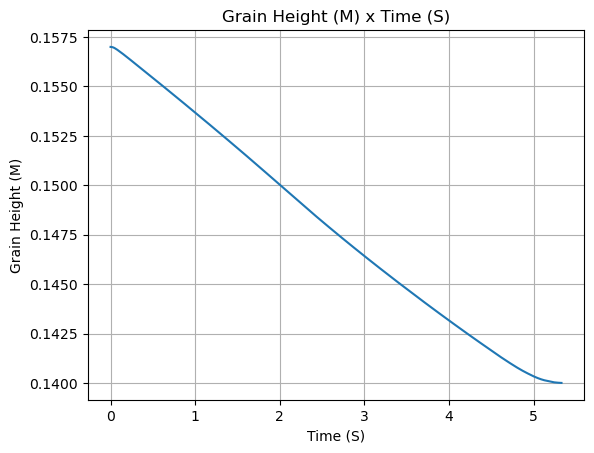

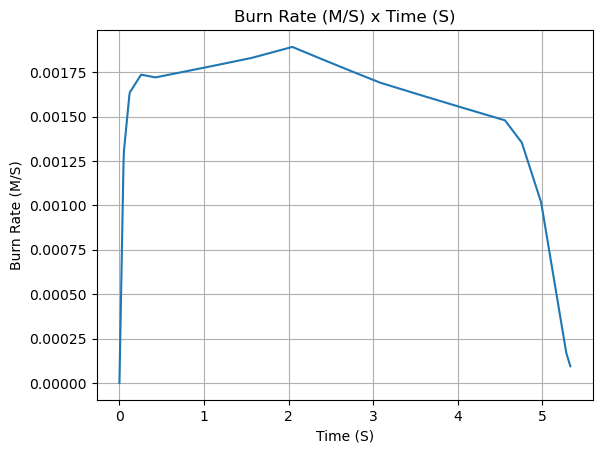

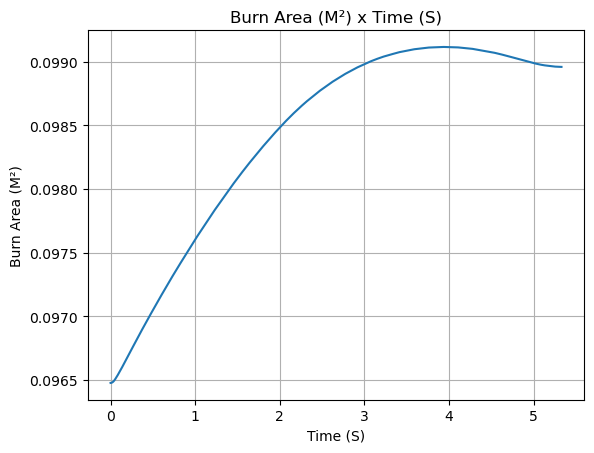

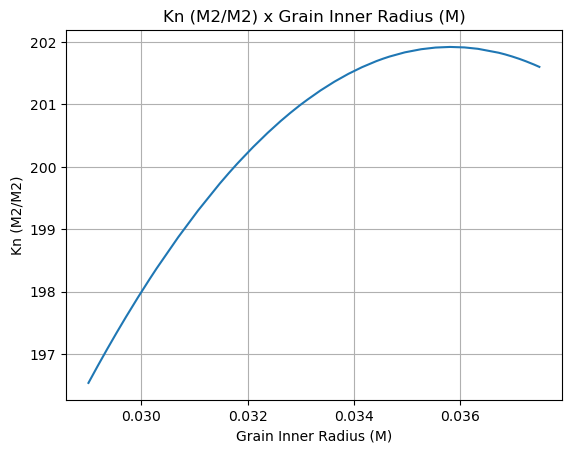

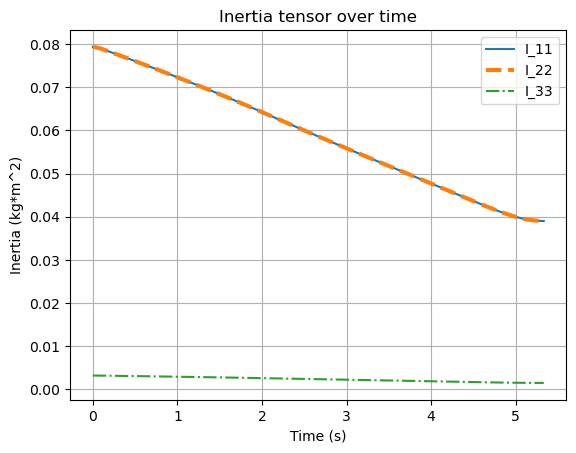

In [38]:
PRO75L645 = SolidMotor(
    thrust_source="assets/motors/Cesaroni_3419L645-P.eng",
    dry_mass=1.608,  # kilograms (launch mass=3.752, wet=2.144)
    dry_inertia=(0.039, 0.039, 0.0015),  # kg*m^2
    nozzle_radius=37.5 / 1000,  # of nozzle exit in meters
    grain_number=3,  # Number of propellant grains
    grain_density=1815,  # kg/m^3
    grain_outer_radius=37.5 / 1000,  # meters
    grain_initial_inner_radius=29 / 1000,  # meters
    grain_initial_height=157 / 1000,  # meters
    grain_separation=5 / 1000,  # meters
    grains_center_of_mass_position=0.343,
    center_of_dry_mass_position=0.231,  # formula: lenngth of the aft part of the motor / (length of the aft part of the motor + length of the forward part of the motor)
    nozzle_position=0.0,  # relative to the combustion chamber
    burn_time=5.33,  # seconds
    throat_radius=12.5 / 1000,  # meters
    coordinate_system_orientation="nozzle_to_combustion_chamber",  # Orientation of the coordinate system -> EXTREMLY IMPORTANT
)
PRO75L645.all_info()

### 3 - Rocket


In [39]:
rocket = Rocket(
    radius=0.051,  # (r) body in meters 5.1cm = 0.051m
    mass=4.843,  # kg (dry)
    inertia=(1.24, 1.38, 0.3),  # Moments of inertia of the rocket in kg*m^2
    power_off_drag="assets/aero/cd_power_off.csv",  # power-off drag curve csv
    power_on_drag="assets/aero/cd_power_on.csv",  # power-on drag curve csv
    center_of_mass_without_motor=1.81 - 0.891,
    coordinate_system_orientation="tail_to_nose",  # MUST be relative to the coordinate system defined in the motor
)

####I think this needs to be updated -Ali
rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.7,  # relative to the rocket nozzle
    lower_button_position=0.15,  # relative to the rocket nozzle
    angular_position=180,  # degrees
)

rocket.add_motor(PRO75L645, position=0)

### 4 - Aero surfaces


In [40]:
nose_cone = rocket.add_nose(
    length=0.468, kind="vonKarman", position=1.81
)  # length in meters, relative to nozzle

In [41]:
fin_set = rocket.add_fins(
    n=4,
    root_chord=0.18,  # meters
    tip_chord=0.06,  # meters
    span=0.109,  # meters (aka height)
    position=1.81 - 1.62,  # relative to the rocket base
    cant_angle=0,  # radians
    airfoil=("assets/aero/clv_alpha.csv", "degrees"),
    sweep_length=0.11,
)

In [42]:
tail = rocket.add_tail(
    top_radius=0.061,  # meters
    bottom_radius=0.041,  # meters
    length=0.07,  # meters
    position=0.07,  # relative to the rocket base
)

### 5 - Recovery


In [43]:
main_para = rocket.add_parachute(
    "Main",  # name
    cd_s=0.8*3.14*1.17^2/4,  # Drag coefficient of the parachute in m^2
    trigger=600,  # altitude in meters OR an event
    sampling_rate=105,
    lag=1.5,  # seconds
    noise=(0, 8.3, 0.5),
)

drogue_para = rocket.add_parachute(
    "Drogue",  # name
    cd_s=0.8*3.14*0.4^2/4,  # Drag coefficient of the parachute in m^2
    trigger="apogee",  # altitude in meters OR an event
    sampling_rate=105,
    lag=1.5,  # seconds
    noise=(0, 8.3, 0.5),
)


Inertia Details

Rocket Mass: 4.843 kg (without motor)
Rocket Dry Mass: 6.451 kg (with unloaded motor)
Rocket Loaded Mass: 7.969 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 1.850 kg*m2
Rocket Inertia (with unloaded motor) 22: 1.990 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.301 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.051 m
Rocket Frontal Area: 0.008171 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.171 m
Rocket Center of Dry Mass - Nozzle Exit: 0.748 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.405 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.077 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 10.033/rad
Tail Lift Coefficient Derivative: -1.569/ra

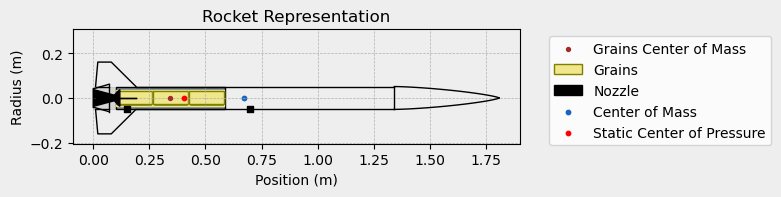


Mass Plots
----------------------------------------


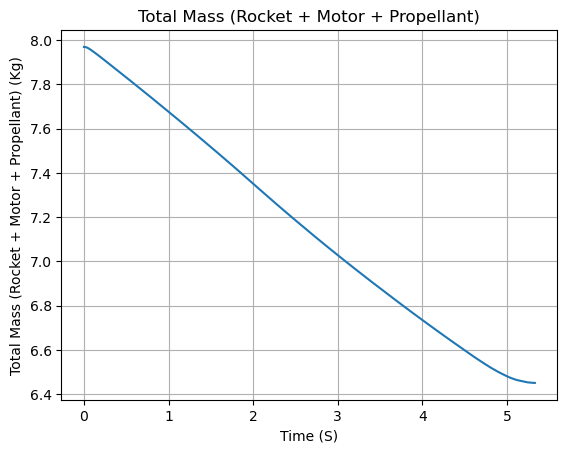

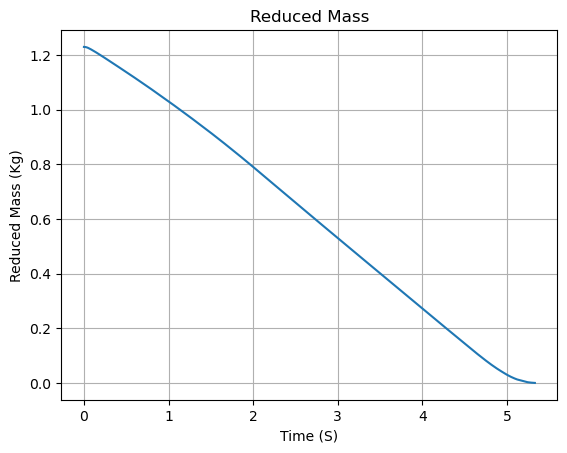


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


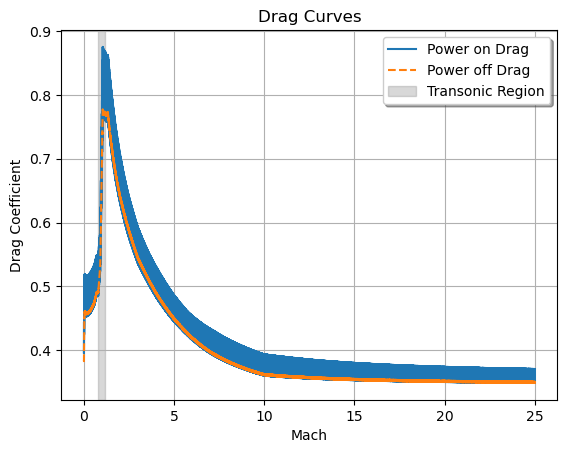


Stability Plots
--------------------


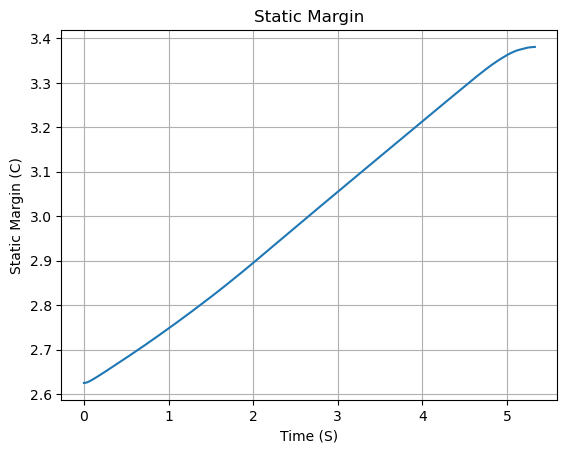

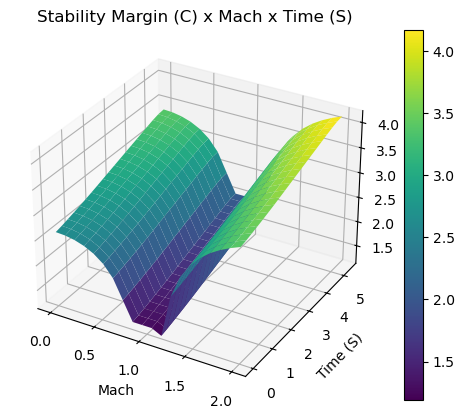


Thrust-to-Weight Plot
----------------------------------------


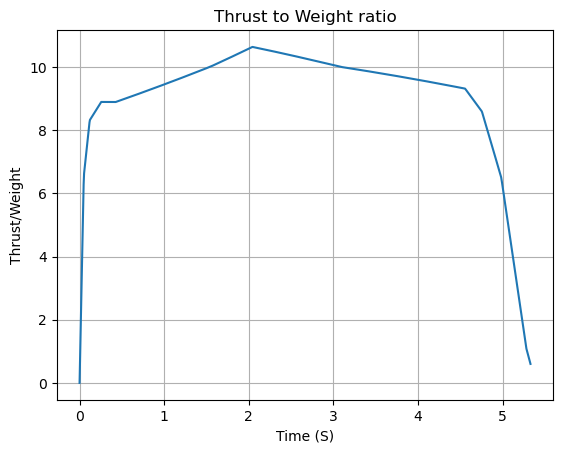

In [44]:
rocket.all_info()

## Flight

Flight Trajectory

- Yellow Line: Altitude (height over time)
- Red Line: Vertical Velocity (speed in the vertical direction)
- Purple Line: Acceleration (rate of change of velocity)
- Teal/Cyan Line: Drag Force (aerodynamic drag acting on the rocket)



Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 160.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.398 | e1: -0.021 | e2: 0.048 | e3: -0.916
Euler Angles - Spin φ : 0.00° | Nutation θ: -6.00° | Precession ψ: -133.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.625 c


Surface Wind Conditions

Frontal Surface Wind Speed: 8.70 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 12 m
Launch Rail Inclination: 84.00°
Launch Rail Heading: 133.00°


Rail Departure State

Rail Departure Time: 0.591 s
Rail Departure Velocity: 41.707 m/s
Rail Departure Stability Margin: 2.679 c
Rail Departure Angle of Attack: 11.973°
Rail Departure Thrust-Weight Ratio: 9.045
Rail Departure Reynolds Number: 2.874e+05


Burn out State

Burn out time: 5.330 s
Altitude at burn out: 1198.837 m (ASL) | 1038.837 m (AGL)
Rocket speed at burn out: 320.251 m/s
Freestream v

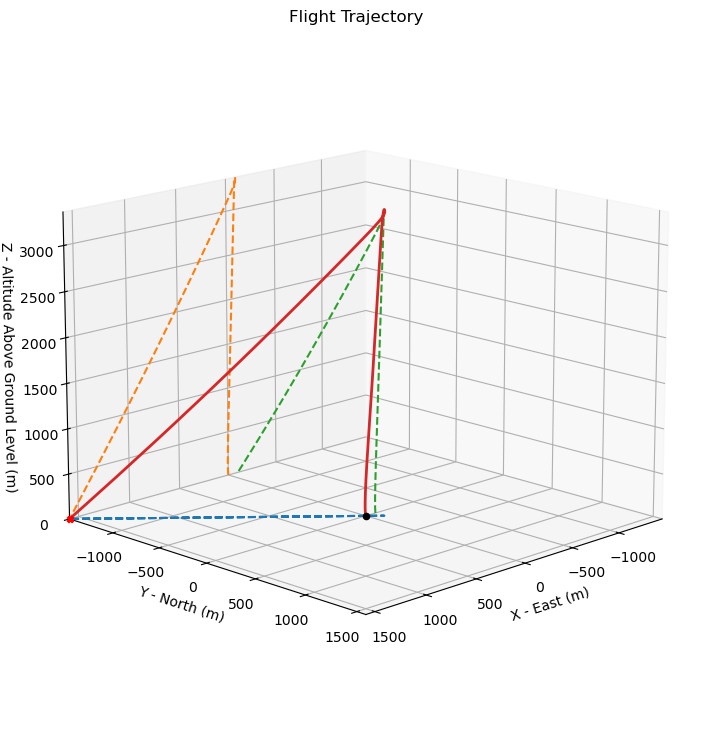



Trajectory Kinematic Plots



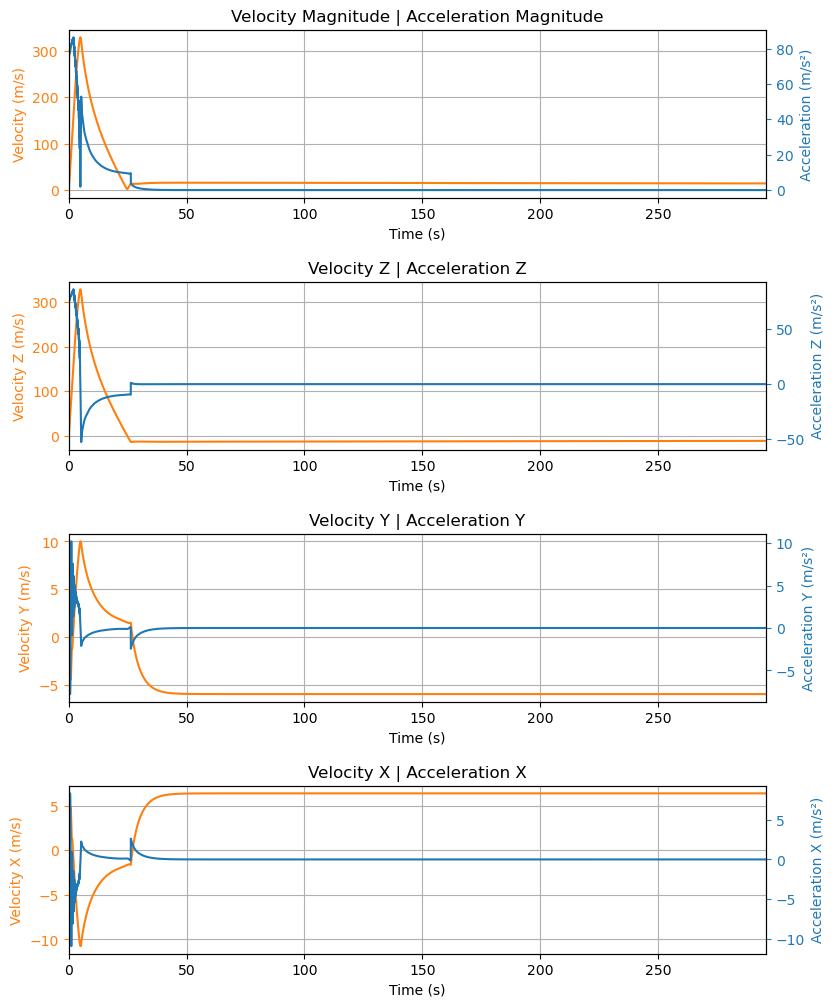



Angular Position Plots



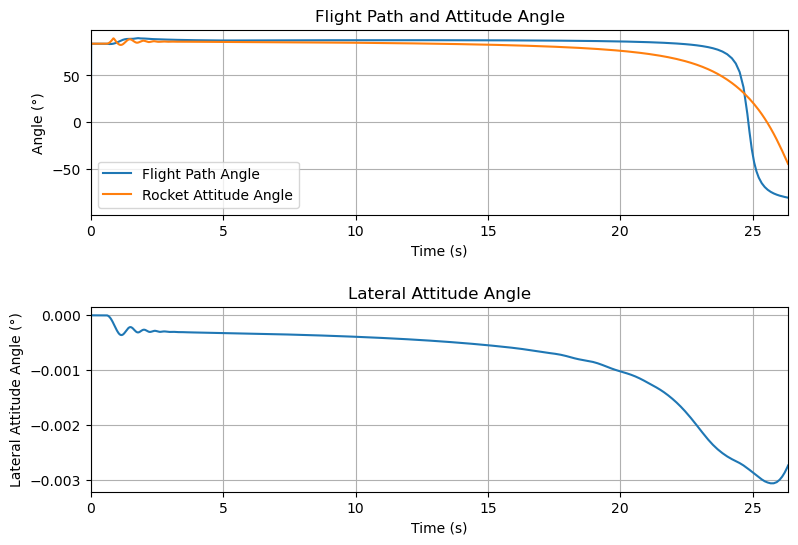



Path, Attitude and Lateral Attitude Angle plots



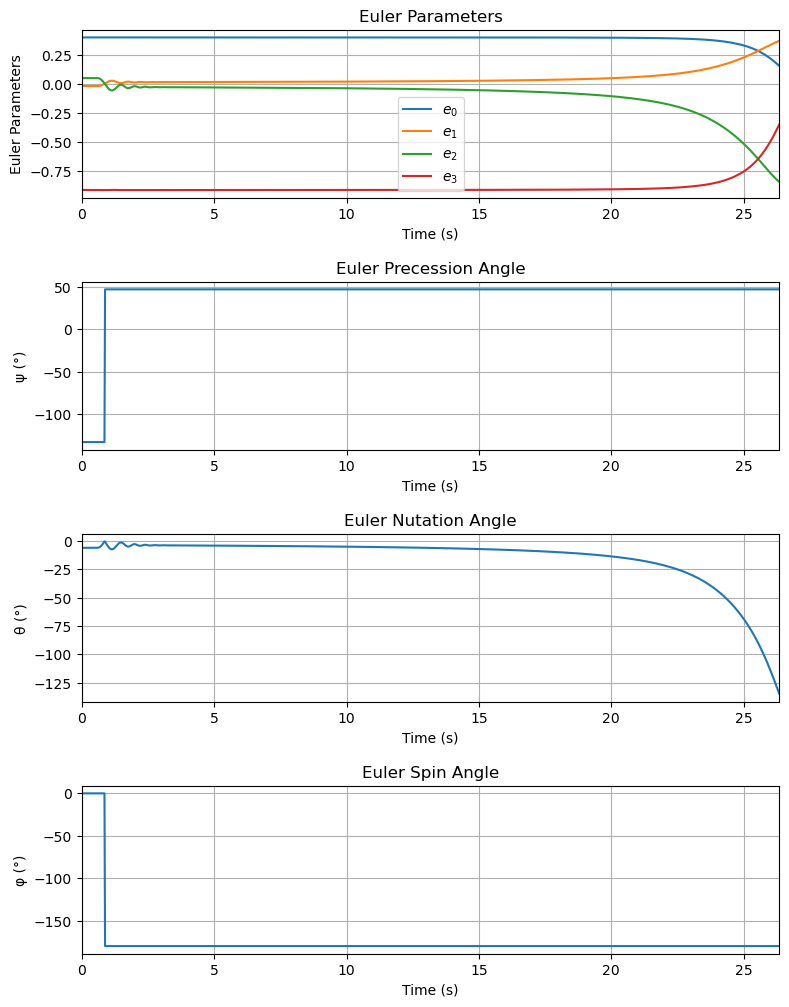



Trajectory Angular Velocity and Acceleration Plots



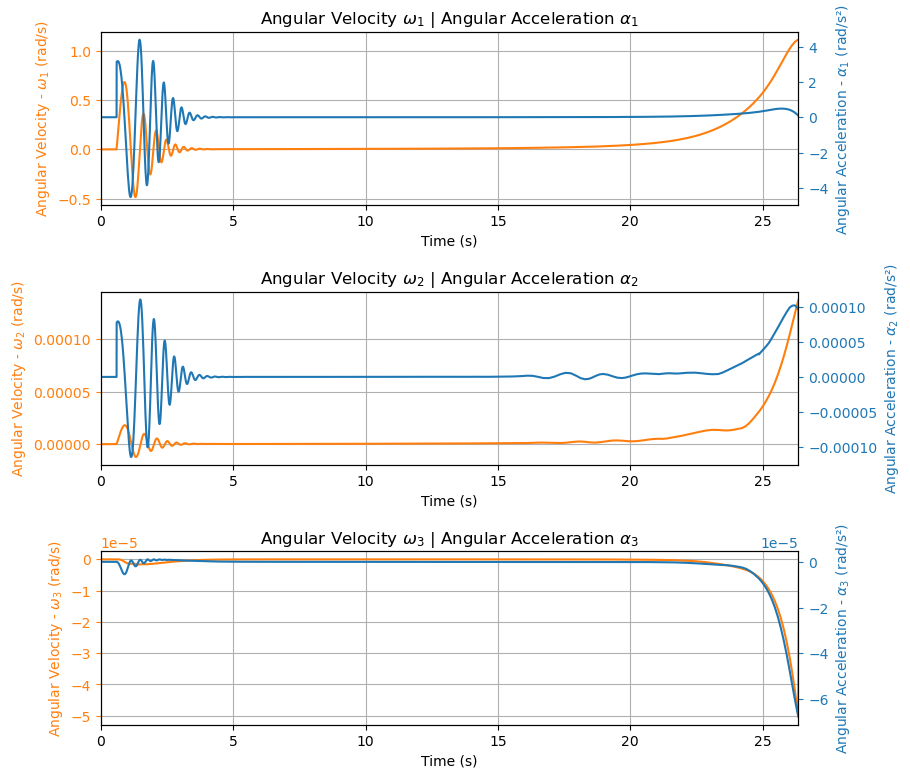



Aerodynamic Forces Plots



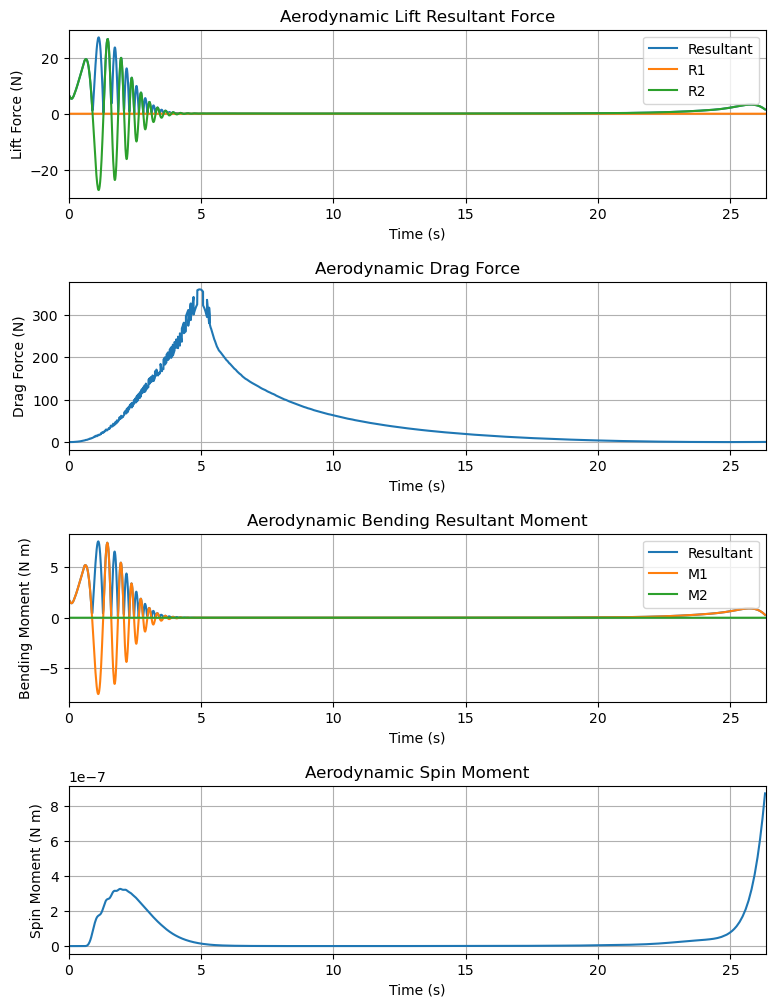



Rail Buttons Forces Plots



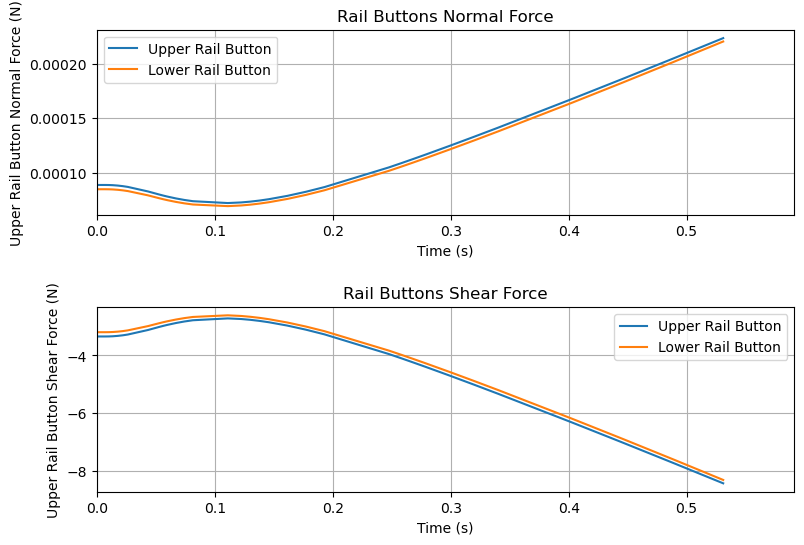



Trajectory Energy Plots



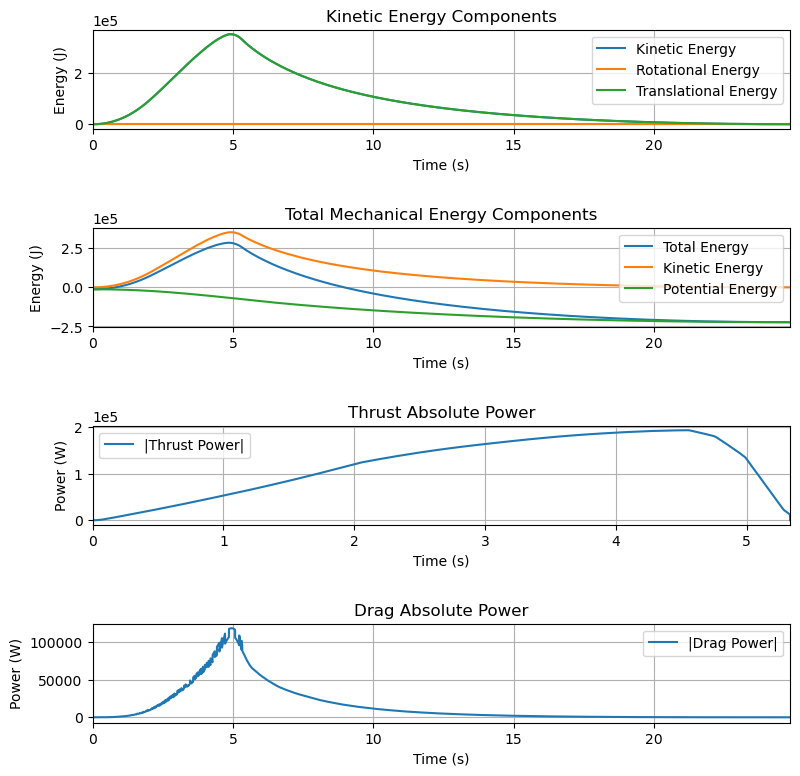



Trajectory Fluid Mechanics Plots



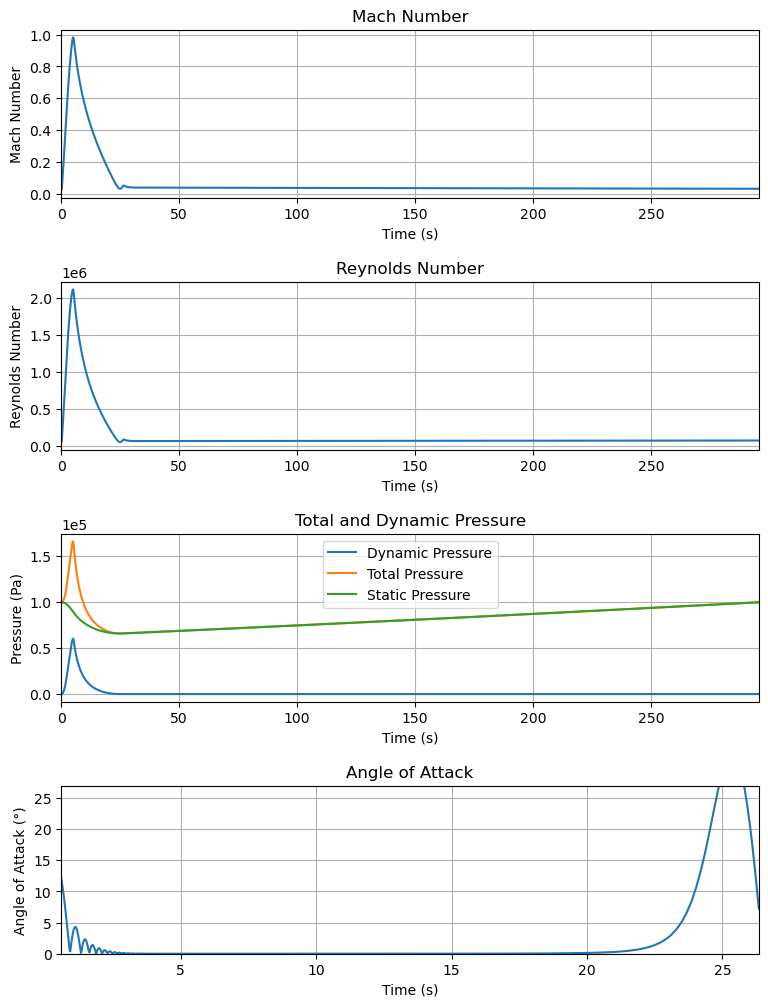



Trajectory Stability and Control Plots



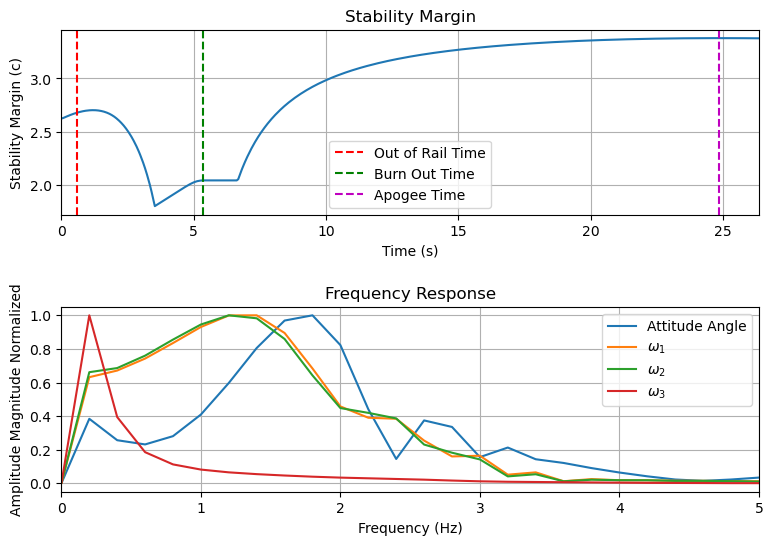



Rocket and Parachute Pressure Plots



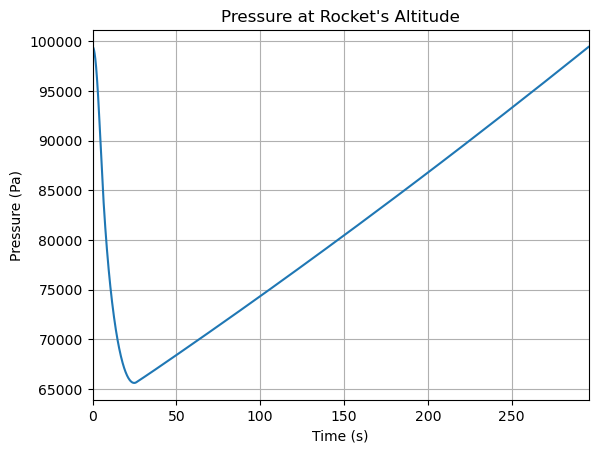


Parachute:  Main


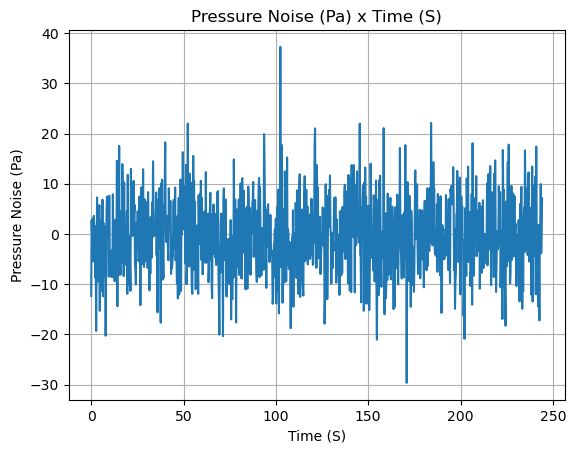

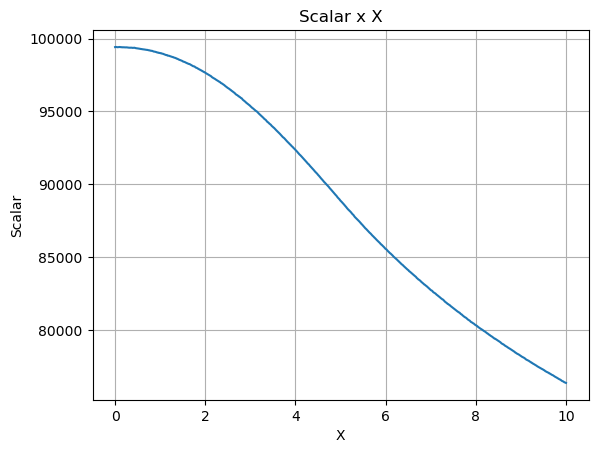

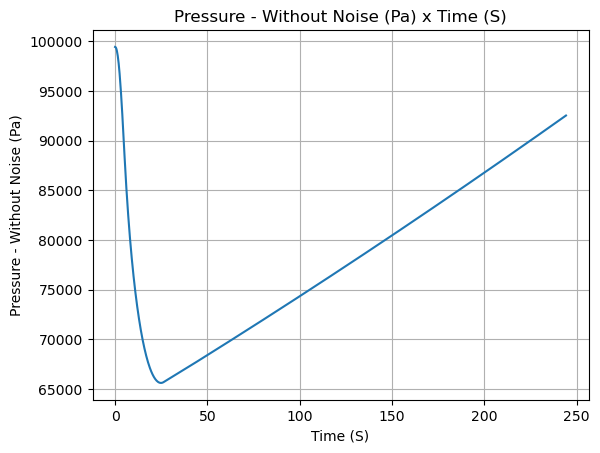


Parachute:  Drogue


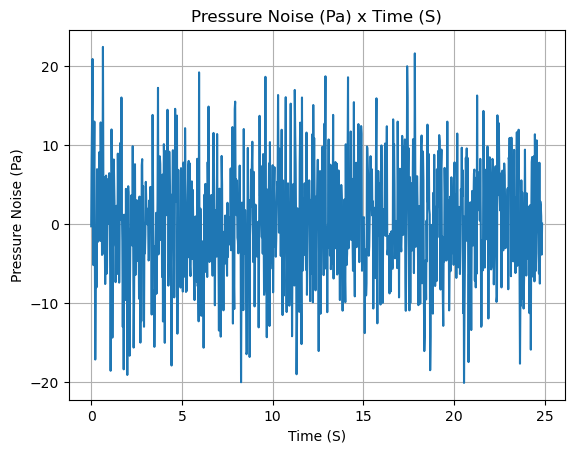

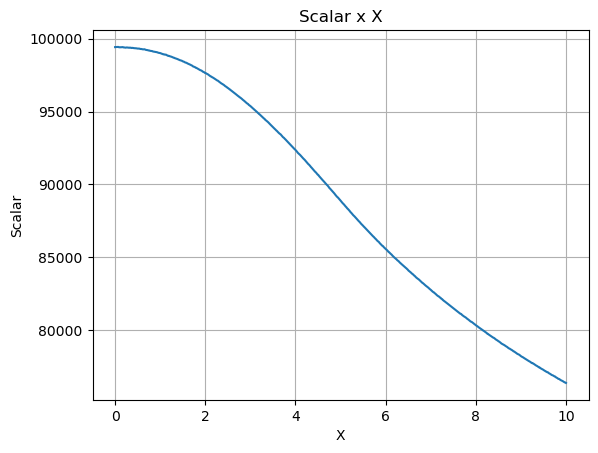

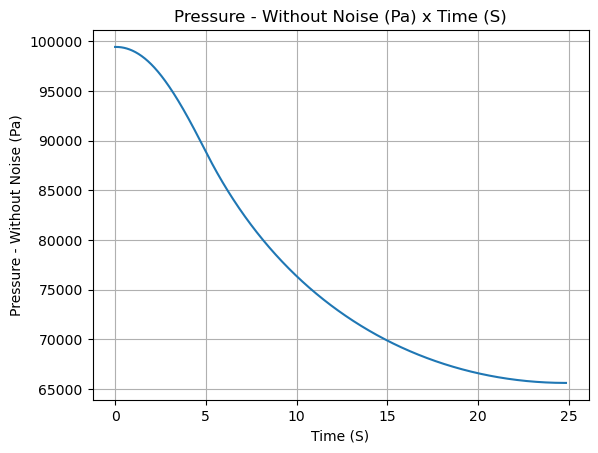

In [45]:
flight = Flight(
    rocket=rocket,
    environment=launchpad,
    rail_length=12,  # meters
    inclination=84,  # launch rail (in degrees)
    heading=133,  # launch rail (in degrees)
)
flight.all_info()

## Export


In [46]:
flight.export_kml(file_name="assets/results/maxdownwind.kml")

File  assets/results/maxdownwind.kml  saved with success!
